### Identifying State Transitions in Melanoma During Drug-Induced Idling
C Heiser, Spring 2019  
  
---
The purpose of this work is to use cell lineage tracing via molecular barcodes and single-cell transcriptomic analyses to identify population-level heterogeneity and cell-state plasticity in BRAF-mutated melanoma (SKMEL5). 

Requirements:  
[`codyheiser/seq-tools/`](https://github.com/codyheiser/seq-tools)

In [1]:
# load files and packages
from fst_utils import *
from fcc_utils import *
from fcc_DRs import *
from utilityfunctions import *
sys.path.append('../seq-tools/'); from seq_analysis import *

%matplotlib inline

Using TensorFlow backend.


### 0. Confirm Barcode Abundance
---
Lineage barcodes are detected in scRNA-seq by poly-T capture of transcribed barcode mRNA. A targeted amplicon sequencing panel was developed to query genomic barcode content to determine global abundance in population, which should corroborate the cell number (*n_cells*) associated with each barcode in scRNA-seq dataset.  

Read in scRNA-seq data with associated barcode UMIs

In [2]:
%%time
# untreated control BRAF melanoma cell line (SKMEL5)
U = RNA_counts.from_file(datafile='untreated/untreated_raw.csv.gz', cells_axis=1, barcodefile='untreated/Untreated_LineageBC_cellBC.csv')
# treated, idling BRAF melanoma cell line (SKMEL5)
I = RNA_counts.from_file(datafile='idling/treated_raw.csv.gz', cells_axis=1, barcodefile='idling/Treated_LineageBC_cellBC.csv')

CPU times: user 32.2 s, sys: 4.62 s, total: 36.9 s
Wall time: 37.5 s


Normalize barcode counts within each scRNA-seq set 

In [27]:
U_RNA_counts = pd.DataFrame(U.barcode_counts(IDs='all'))
U_RNA_counts_norm = U_RNA_counts.div(U_RNA_counts.sum(axis=0), axis=1)

In [29]:
I_RNA_counts = pd.DataFrame(I.barcode_counts(IDs='all'))
I_RNA_counts_norm = I_RNA_counts.div(I_RNA_counts.sum(axis=0), axis=1)

Read in associated __Read 1__ barcode assay results files, where barcodes were extracted using  
[`codyheiser/seq-tools/seq_extraction.sh`](https://github.com/codyheiser/seq-tools)

In [7]:
%%time
U_R1 = pd.read_csv(gzip.open('untreated/2898-CH-1-CGAAACAT-GTTCAGAG_S1_R1_001.txt.gz'), sep='\t', header=None)
I_R1 = pd.read_csv(gzip.open('idling/2898-CH-2-GGCCACAT-GTTCAGAG_S2_R1_001.txt.gz'), sep='\t', header=None)

CPU times: user 12.6 s, sys: 578 ms, total: 13.2 s
Wall time: 13.4 s


Read in associated __Read 2__ barcode assay results files, where barcodes were extracted using  
[`codyheiser/seq-tools/seq_extraction.sh`](https://github.com/codyheiser/seq-tools)  
and [`codyheiser/seq-tools/rev_comp.sh`](https://github.com/codyheiser/seq-tools)

In [8]:
%%time
U_R2 = pd.read_csv(gzip.open('untreated/2898-CH-1-CGAAACAT-GTTCAGAG_S1_R2_001_REVCOMP.txt.gz'), sep='\t', header=None)
I_R2 = pd.read_csv(gzip.open('idling/2898-CH-2-GGCCACAT-GTTCAGAG_S2_R2_001_REVCOMP.txt.gz'), sep='\t', header=None)

CPU times: user 12.6 s, sys: 664 ms, total: 13.2 s
Wall time: 13.4 s


Now add UMIs from __Read 1__ and __Read 2__ to get totals

In [9]:
U_bc = U_R1.append(U_R2)
I_bc = I_R1.append(I_R2)

Count unique barcode abundances in untreated and idling datasets

In [10]:
U_bc_counts = pd.DataFrame(U_bc[0].value_counts())
U_bc_counts.rename(index=str, columns={0: "Count"}, inplace=True)

In [11]:
I_bc_counts = pd.DataFrame(I_bc[0].value_counts())
I_bc_counts.rename(index=str, columns={0: "Count"}, inplace=True)

Finally, convert counts to fractions of total to normalize for comparison with scRNA-seq data

In [14]:
U_bc_counts_norm = U_bc_counts.div(U_bc_counts.sum(axis=0), axis=1)
I_bc_counts_norm = I_bc_counts.div(I_bc_counts.sum(axis=0), axis=1)

---
Merge scRNA-seq and targeted barcode assay datasets on barcode and print overlay

In [31]:
U_totalcounts = U_RNA_counts_norm.merge(U_bc_counts_norm, left_index=True, right_index=True, how='inner')
U_totalcounts.rename(columns={'Barcode':'U_RNA', 'Count':'U_BC'}, inplace=True)

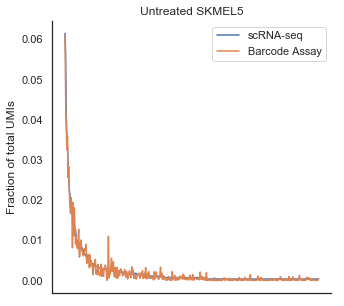

In [32]:
# plot abundance of barcodes to use for distance calcs
plt.figure(figsize=(5,5))
U_totalcounts['U_RNA'].plot(label='scRNA-seq', legend=True)
U_totalcounts['U_BC'].plot(label='Barcode Assay', legend=True)
plt.title('Untreated SKMEL5')
plt.ylabel('Fraction of total UMIs')
sns.despine()
plt.show()

In [33]:
I_totalcounts = I_RNA_counts_norm.merge(I_bc_counts_norm, left_index=True, right_index=True, how='inner')
I_totalcounts.rename(columns={'Barcode':'I_RNA', 'Count':'I_BC'}, inplace=True)

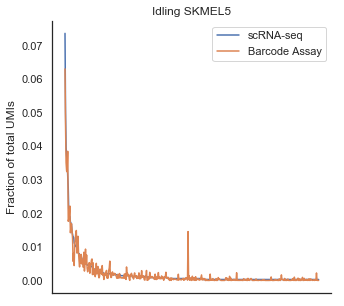

In [34]:
# plot abundance of barcodes to use for distance calcs
plt.figure(figsize=(5,5))
I_totalcounts['I_RNA'].plot(label='scRNA-seq', legend=True)
I_totalcounts['I_BC'].plot(label='Barcode Assay', legend=True)
plt.title('Idling SKMEL5')
plt.ylabel('Fraction of total UMIs')
sns.despine()
plt.show()

Targeted barcode assay __corroborates barcode abundance__ from scRNA-seq results.  
We can confidently trust UMI counts for barcodes in RNA-seq data and use barcode subpopulations to investigate cell state transitions.

### 1. Perform Combined Dimensionality Reduction
---
See if we can detect unique population states in _untreated_ (U) and _idling_ (I) datasets by performing PCA and UMAP together

In [88]:
# combine untreated and idling data to perform combined DR
counts = U.data.append(I.data)

In [127]:
# combine barcode arrays for untreated and idling data
codes = pd.DataFrame(U.barcodes).append(pd.DataFrame(I.barcodes))
codes['Cell Barcode'] = codes.index
codes = codes[~codes.index.duplicated(keep='first')]

In [128]:
counts_obj = RNA_counts(data=counts, barcodes=codes) # generate RNA_counts obj with combined data

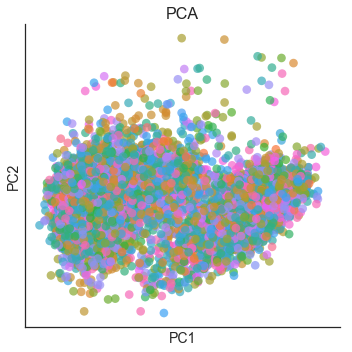

In [129]:
# arcsinh-normalize fractional counts and perform 100-component PCA
counts_PCA = fcc_PCA(matrix=counts_obj.arcsinh_norm(norm='l1'), barcodes=counts_obj.barcodes, n_components=100)
counts_PCA.plot_barcodes()

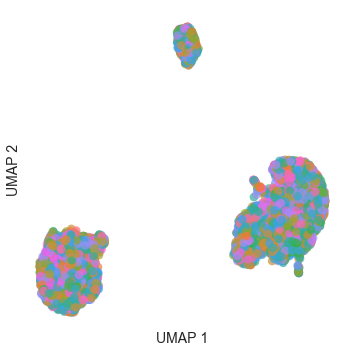

CPU times: user 19.7 s, sys: 1.09 s, total: 20.8 s
Wall time: 20.4 s


In [130]:
%%time
# perform UMAP on total dataset
counts_UMAP = fcc_UMAP(matrix=counts_PCA.results, barcodes=counts_PCA.barcodes, perplexity=30)
counts_UMAP.plot_barcodes()

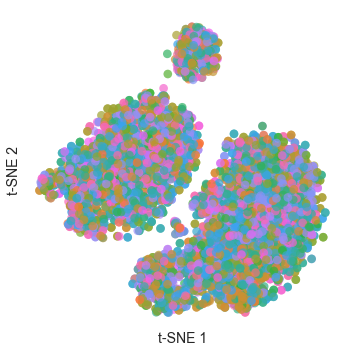

CPU times: user 55.4 s, sys: 3.21 s, total: 58.6 s
Wall time: 59.5 s


In [136]:
%%time
# perform t-SNE on total dataset
counts_tSNE = fcc_tSNE(matrix=counts_PCA.results, barcodes=counts_PCA.barcodes, perplexity=30)
counts_tSNE.plot_barcodes()

Lineage barcodes are distributed seemingly randomly throughout the population.  
Now color by treatment group:

In [133]:
U_codes = pd.DataFrame(U.barcodes)
U_codes['Barcode'] = 'Untreated'
I_codes = pd.DataFrame(I.barcodes)
I_codes['Barcode'] = 'Idling'
# combine barcode arrays for untreated and idling data
codes = U_codes.append(I_codes)
codes = pd.DataFrame(codes)
codes['Cell Barcode'] = codes.index

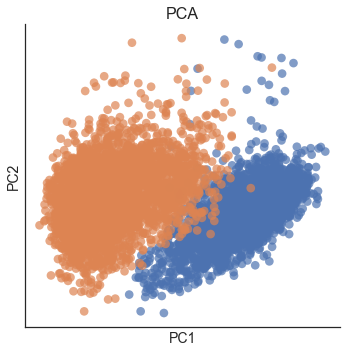

In [134]:
plt.figure(figsize=(5,5))

sns.scatterplot(x=counts_PCA.results[:,0], y=counts_PCA.results[:,1], s=75, alpha=0.7, hue=codes['Barcode'], legend=None, edgecolor='none')
plt.tick_params(labelbottom=False, labelleft=False)
plt.ylabel('PC2', fontsize=14)
plt.xlabel('PC1', fontsize=14)
plt.title('PCA', fontsize=16)

sns.despine()
plt.tight_layout()
plt.show()
plt.close()

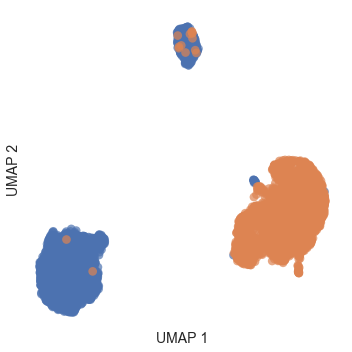

In [135]:
plt.figure(figsize=(5,5))
sns.scatterplot(counts_UMAP.results[:,0], counts_UMAP.results[:,1], s=75, alpha=0.7, hue=codes['Barcode'], legend=None, edgecolor='none')
plt.xlabel('UMAP 1', fontsize=14)
plt.ylabel('UMAP 2', fontsize=14)
plt.tick_params(labelbottom=False, labelleft=False)
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()
plt.close()

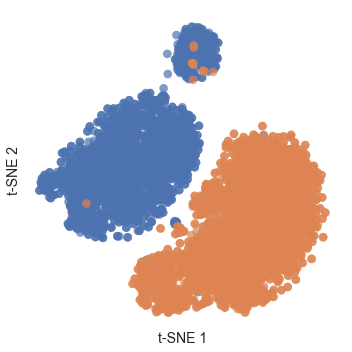

In [137]:
plt.figure(figsize=(5,5))
sns.scatterplot(counts_tSNE.results[:,0], counts_tSNE.results[:,1], s=75, alpha=0.7, hue=codes['Barcode'], legend=None, edgecolor='none')
plt.xlabel('t-SNE 1', fontsize=14)
plt.ylabel('t-SNE 2', fontsize=14)
plt.tick_params(labelbottom=False, labelleft=False)
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()
plt.close()

_Untreated_ and _Idling_ cells cluster pretty well.

### 2. Perform Dimensionality Reduction on Separated treatment datasets
---
